In [3]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize as opt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas_datareader.data as web

import datetime

start = datetime.datetime(2016, 1, 1)

end = datetime.datetime(2017, 12, 31)

## Quandl
Daily financial data (prices of stocks, ETFs etc.) from Quandl. The symbol names consist of two parts: DB name and symbol name. DB names can be all the free ones listed on the Quandl website. Symbol names vary with DB name; for WIKI (US stocks), they are the common ticker symbols, in some other cases (such as FSE) they can be a bit strange. Some sources are also mapped to suitable ISO country codes in the dot suffix style shown above, currently available for BE, CN, DE, FR, IN, JP, NL, PT, UK, US.

ref: 
http://pandas-datareader.readthedocs.io/en/latest/remote_data.html

In [43]:


# f = web.DataReader('AAPL', 'google', start, end)

# A = web.DataReader('AAPL', 'morningstar', start, end)

# f = web.DataReader('AAPL', 'iex', start, end)


symbol = 'WIKI/AAPL'  # or 'AAPL.US'

df = web.DataReader(symbol, 'quandl', '2016-01-01', '2017-12-31')

df.head()

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2017-12-29,170.52,170.590,169.220,169.23,25643711.0,0.0,1.0,170.52,170.590,169.220,169.23,25643711.0
2017-12-28,171.00,171.850,170.480,171.08,15997739.0,0.0,1.0,171.00,171.850,170.480,171.08,15997739.0
2017-12-27,170.10,170.780,169.710,170.60,21672062.0,0.0,1.0,170.10,170.780,169.710,170.60,21672062.0
2017-12-26,170.80,171.470,169.679,170.57,32968167.0,0.0,1.0,170.80,171.470,169.679,170.57,32968167.0
2017-12-22,174.68,175.424,174.500,175.01,16052615.0,0.0,1.0,174.68,175.424,174.500,175.01,16052615.0


We are focus on the adjusted close price.

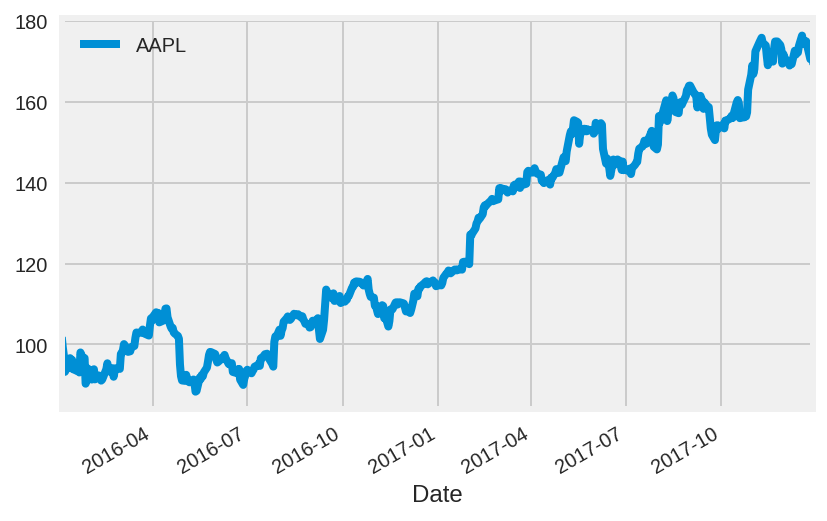

In [136]:
stock = df.loc[:,['AdjClose']]
stock.columns = ['AAPL']
stock.plot()

In [137]:
stock=stock.sort_index()

In [138]:
stock.head()


,AAPL
Date,
2016-01-04,101.783763
2016-01-05,99.233131
2016-01-06,97.291172
2016-01-07,93.185040
2016-01-08,93.677776


In [162]:
def get_stock(tick, start='2016-01-01', end='2017-12-31' ):
    #You have submitted an incorrect Quandl code. Please check your Quandl codes and try again.\n'
    symbol = 'WIKI/' + tick # or tick+'.US'
    df = web.DataReader(symbol, 'quandl', start, end)
    stock = df.loc[:,['AdjClose']]
    stock.columns = [tick]
    stock=stock.sort_index()
    return stock

In [163]:
get_stock('AMZN').head()

,AMZN
Date,
2016-01-04,636.99
2016-01-05,633.79
2016-01-06,632.65
2016-01-07,607.94
2016-01-08,607.05


In [141]:
stock.join(get_stock('AMZN')).head()

,AAPL,AMZN
Date,,
2016-01-04,101.783763,636.99
2016-01-05,99.233131,633.79
2016-01-06,97.291172,632.65
2016-01-07,93.185040,607.94
2016-01-08,93.677776,607.05


In [167]:
ticks = ['AAPL','AMZN','GOOGL','FB','SBUX','NKE','WMT','GE','TSLA']
# for i in ticks[1:]:
#     stock = stock.join(get_stock(i))

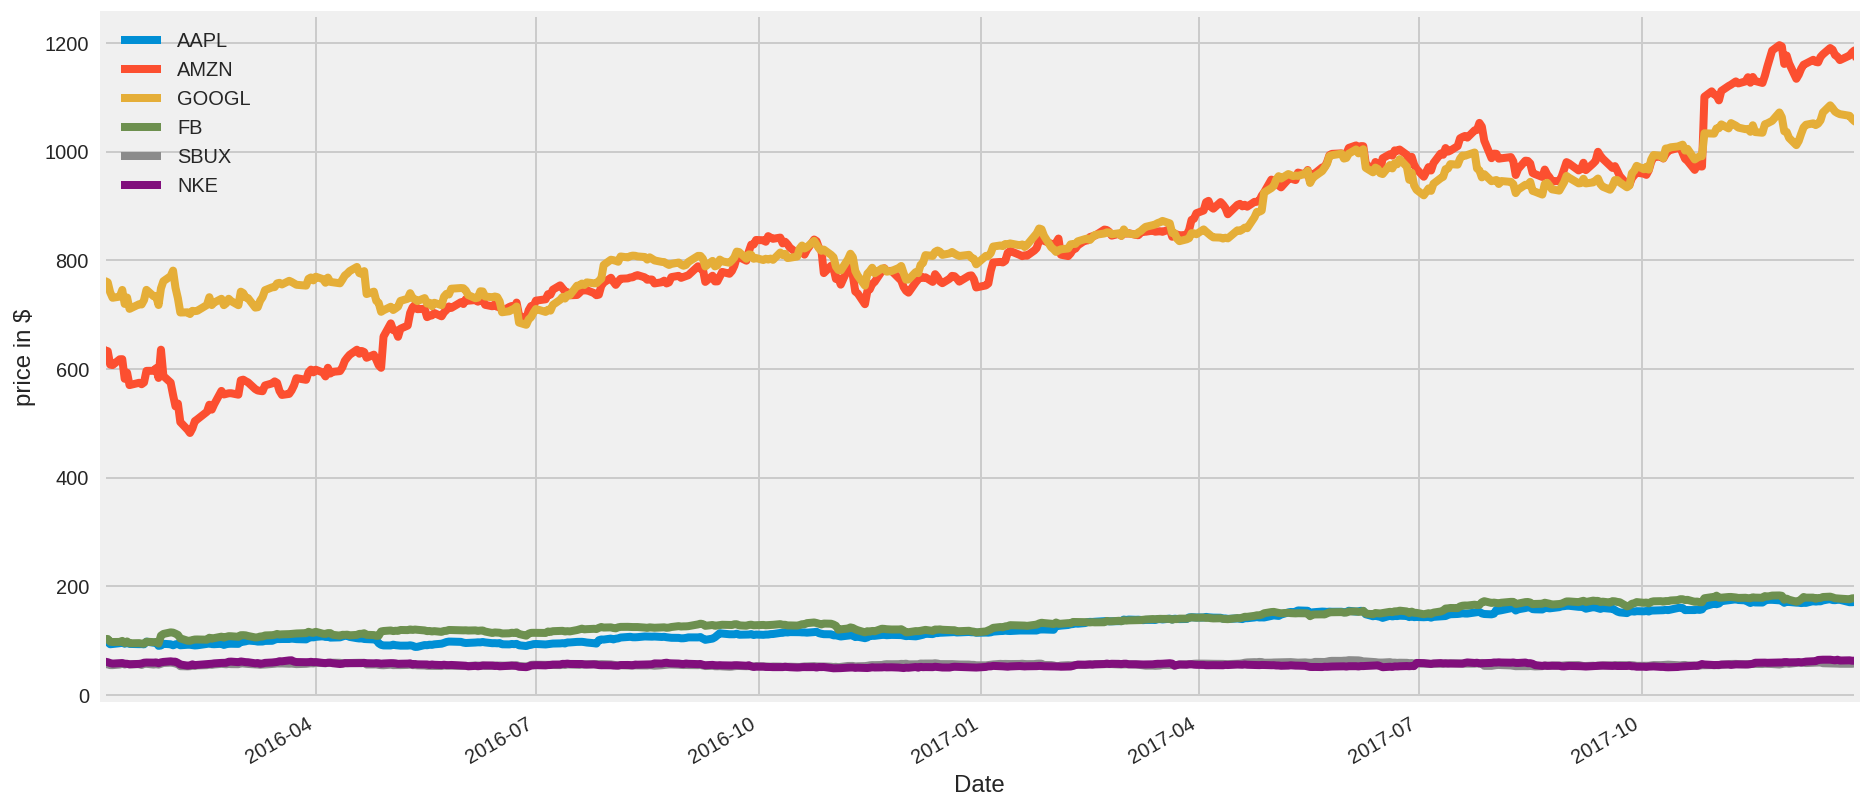

In [143]:

stock.plot(figsize=(14, 7))
plt.ylabel('price in $')

In [179]:
def get_stocks(ticks, start='2016-01-01', end='2017-12-31'):

    stock= get_stock(ticks[0], start, end )
    for i in ticks[1:]:
        stock = stock.join(get_stock(i, start, end ))
    return stock

In [168]:
stocks = get_stocks(ticks)

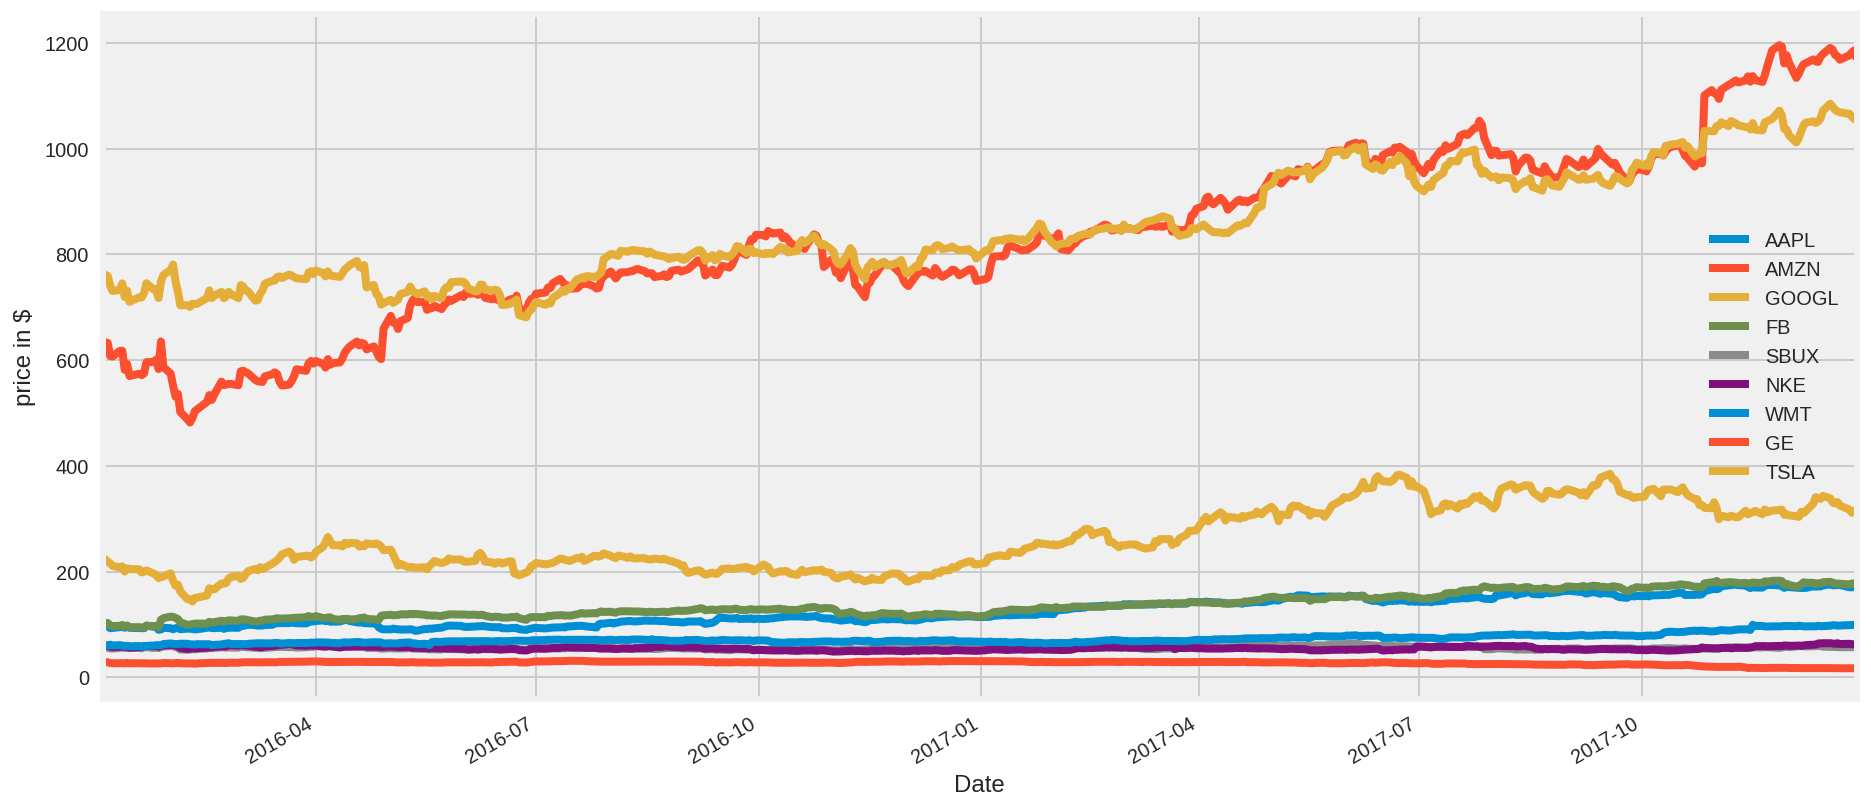

In [170]:
stocks.plot(figsize=(14, 7))
plt.ylabel('price in $')

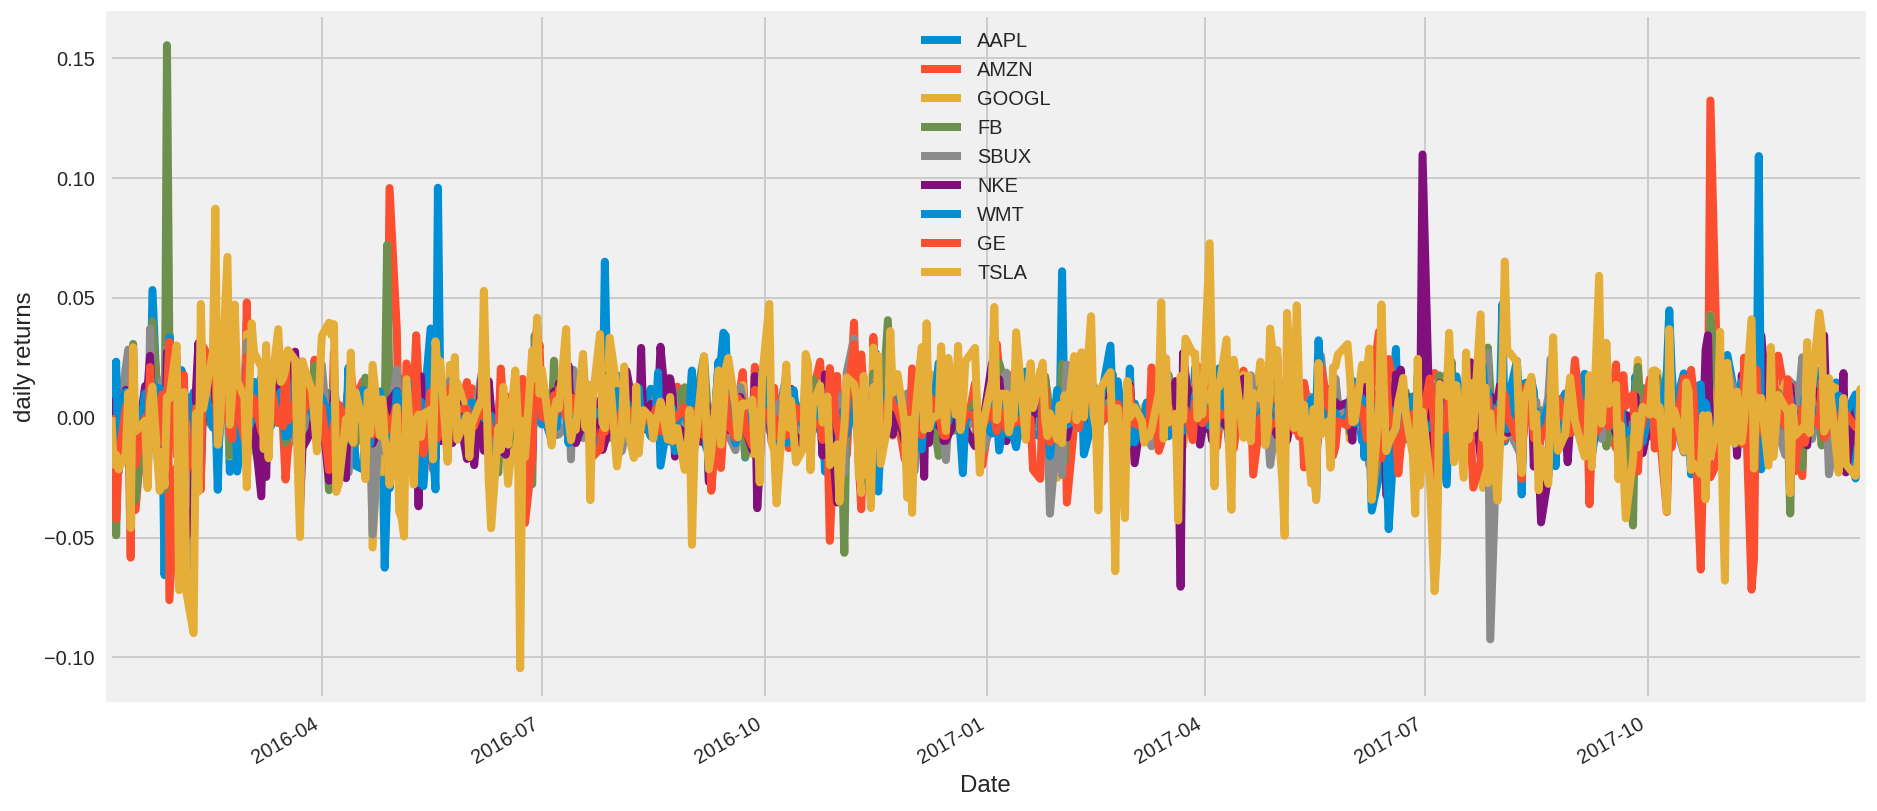

In [172]:

returns = stocks.pct_change()
returns.plot(figsize=(14, 7))
plt.ylabel('daily returns')

In [173]:

mean_returns = returns.mean()
cov_matrix = returns.cov()

In [174]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(weights.T@cov_matrix@weights) * np.sqrt(252)
    return std, returns

## Modern Portfolio Theory (MPT) 

Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz and published under the title “Portfolio Selection” in the Journal of Finance in 1952.

![](https://cdn-images-1.medium.com/max/2000/1*z3qQHXi4CyTtb_oSKInvYA.png)

formula can be expressed in matrix calculation

![](https://cdn-images-1.medium.com/max/1600/1*Fe8_FBagP5p3RHBhzW2Ijg.gif)

## Risk free rate:

1-Year Treasury Bill: Secondary Market Rate (DTB1YR)

ref:

https://fred.stlouisfed.org/series/DTB1YR


In [147]:
Rf = web.DataReader(['DTB1YR'], 'fred', start, '2018-03-07')

In [148]:
Rf.tail()

,DTB1YR
DATE,
2018-02-28,2.01
2018-03-01,1.99
2018-03-02,2.00
2018-03-05,2.00
2018-03-06,2.00


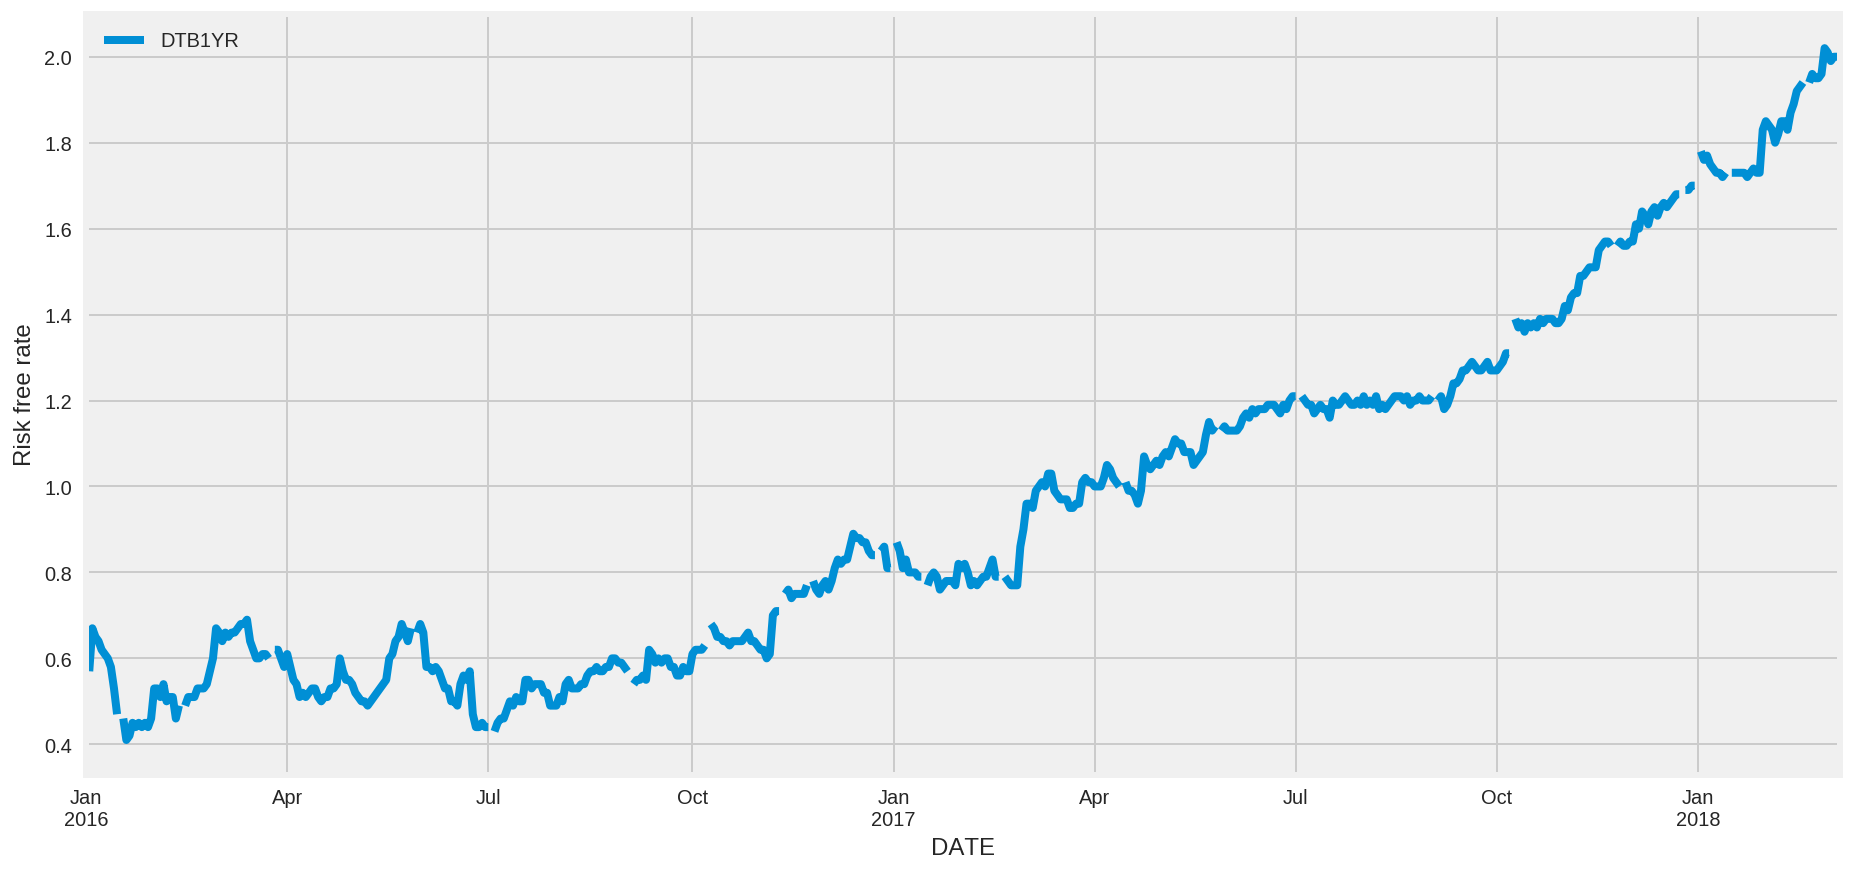

In [149]:
Rf.plot(figsize=(14, 7))
plt.ylabel('Risk free rate')



### Sharpe ratio
The Sharpe ratio was derived in 1966 by William Sharpe, another winner of a Nobel Memorial Prize in Economic Sciences.
![](https://cdn-images-1.medium.com/max/1600/1*aXiygSH2vLBUwAFTZKW47g.jpeg)
Risk-adjusted return refines an investment’s return by measuring how much risk is involved in producing that return, which is generally expressed as a number or rating. 


![](https://cdn-images-1.medium.com/max/1500/1*fo_KcYDFTQ-C9iriE67r2w.png)

In [150]:
num_portfolios = 25000
risk_free_rate = Rf.iloc[-1]['DTB1YR']

In [151]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = np.zeros((len(mean_returns),num_portfolios))
    for i in np.arange(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record[:,i] =weights
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [175]:
mean_returns.index

Index(['AAPL', 'AMZN', 'GOOGL', 'FB', 'SBUX', 'NKE', 'WMT', 'GE', 'TSLA'], dtype='object')

In [176]:
def display_simulated_ef_with_random(returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[:,max_sharpe_idx],index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[:,min_vol_idx],index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    # anualized volatility and return
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    # plot each volatility and return for each asset
    for i, txt in enumerate(mean_returns.index):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    
    
    # Monte Carlo samples
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Maximum Sharp ratio portfolio
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    # Minimum Volatility portfolio
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.25
Annualised Volatility: 0.2


            AAPL   AMZN  GOOGL     FB  SBUX   NKE   WMT    GE   TSLA
allocation  2.03  24.35  13.78  20.21  1.13  2.21  0.12  2.43  33.73
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.06
Annualised Volatility: 0.12


            AAPL  AMZN  GOOGL    FB  SBUX    NKE    WMT     GE  TSLA
allocation  9.04  1.23   8.17  3.23  11.4  12.23  24.84  29.03  0.82


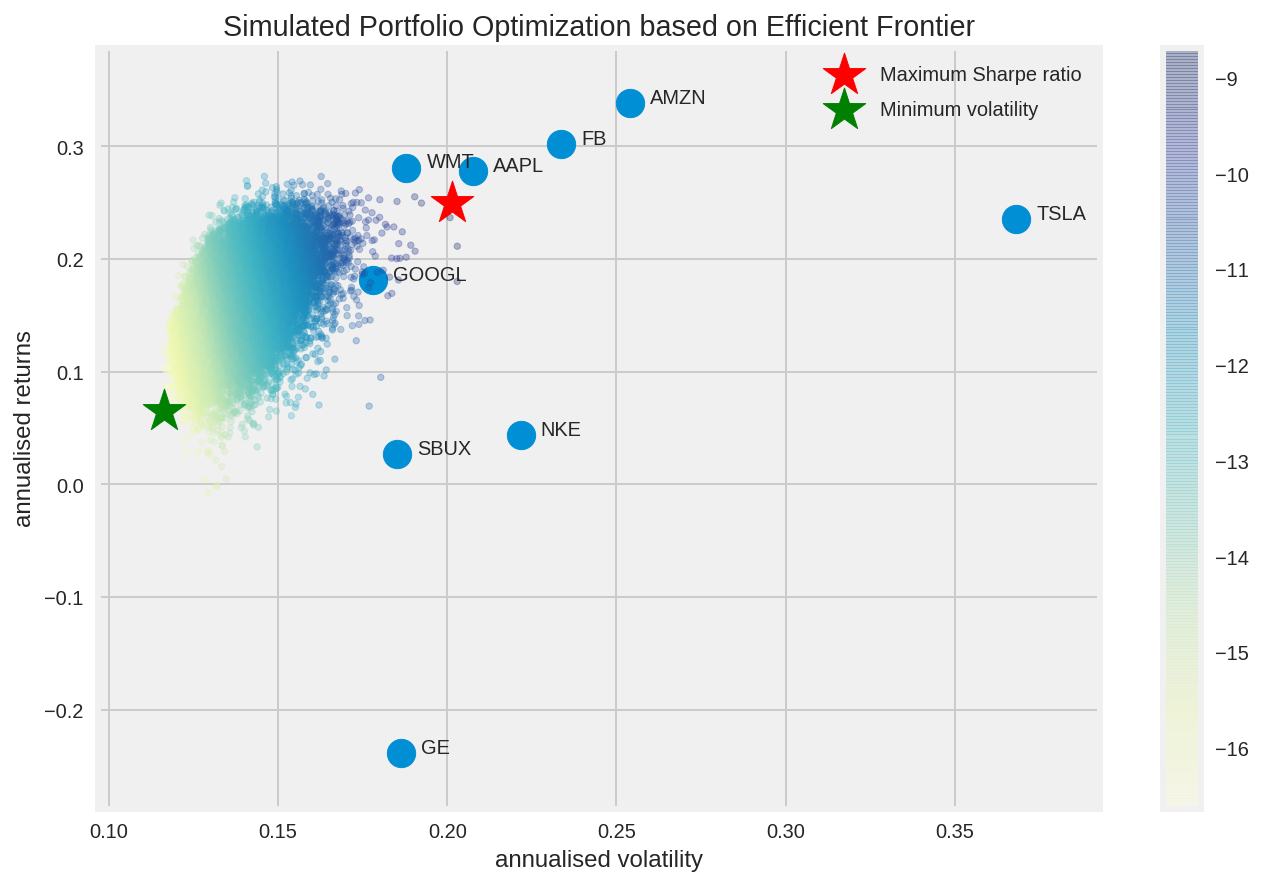

In [177]:
display_simulated_ef_with_random(returns,mean_returns, cov_matrix, num_portfolios, risk_free_rate)
